In [2]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [12]:
pf_data <- read_csv("final_data.csv") |>
        #mutate(max_portfolio_return_name = as_factor(max_portfolio_return_name))|>
        select(-year, -max_portfolio_return_name) |>
        as_tibble()

head(pf_data)

Rows: 25 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): max_portfolio_return_name
dbl (5): year, annual_inflation, real_gdp_growth_rate_percentage, annual_une...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


annual_inflation,real_gdp_growth_rate_percentage,annual_unemployment_rate,max_portfolio_return_value
<dbl>,<dbl>,<dbl>,<dbl>
2.337690,4.4,4.950000,22.37
1.552279,4.5,4.508333,18.26
2.188027,4.8,4.216667,20.79
3.376857,4.1,3.991667,4.77
2.826171,1.0,4.733333,3.38
1.586032,1.7,5.775000,4.77


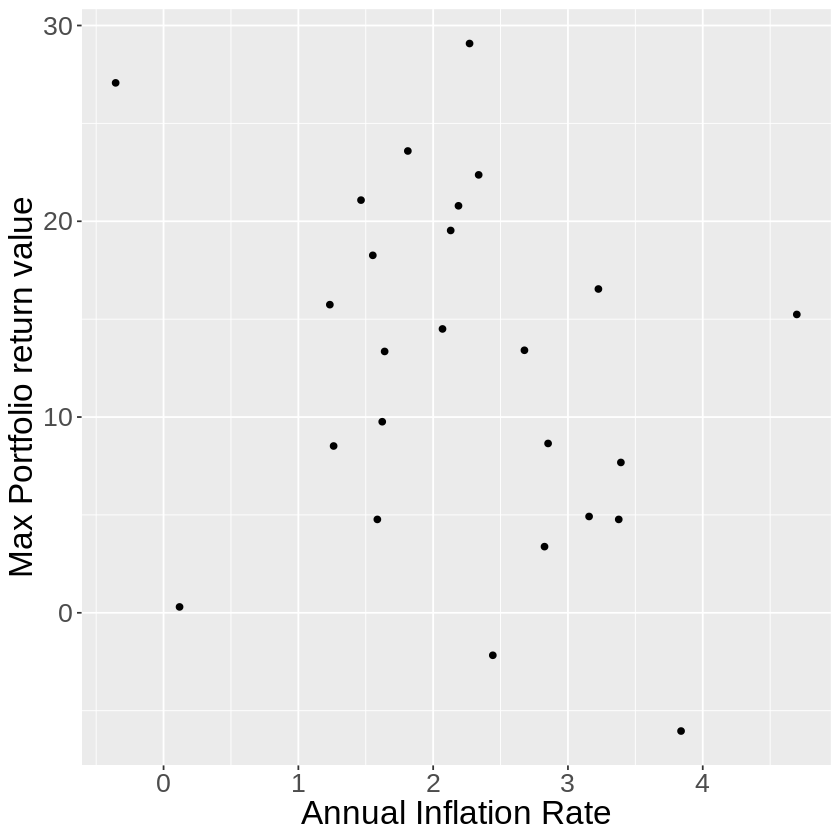

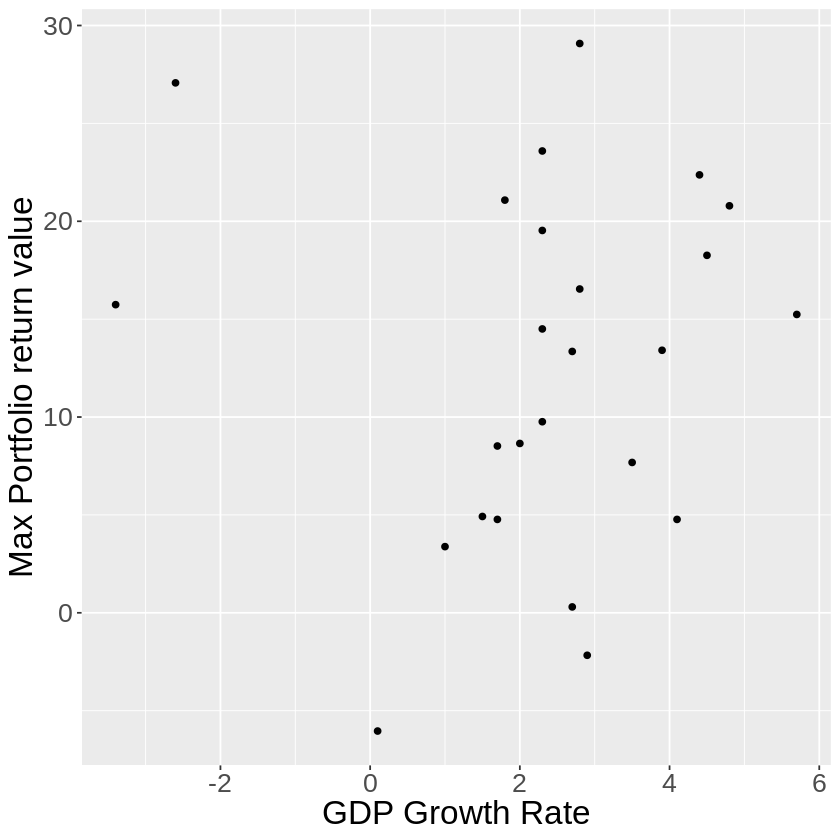

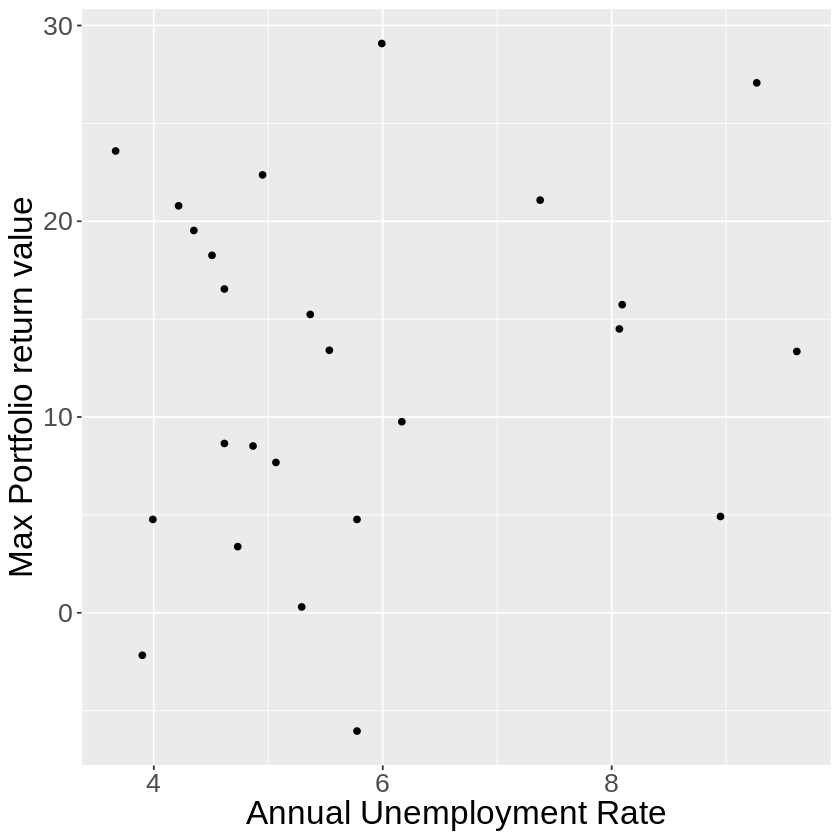

In [32]:
pf_inf_plot <- pf_data |>
        ggplot(aes(x = annual_inflation, y = max_portfolio_return_value)) +
        geom_point() +
        labs(x = "Annual Inflation Rate", y = "Max Portfolio return value") +
        theme(text = element_text(size = 20))

pf_gdp_plot <- pf_data |>
        ggplot(aes(x = real_gdp_growth_rate_percentage, y = max_portfolio_return_value)) +
        geom_point() +
        labs(x = "GDP Growth Rate", y = "Max Portfolio return value") +
        theme(text = element_text(size = 20))

pf_une_plot <- pf_data |>
        ggplot(aes(x = annual_unemployment_rate, y = max_portfolio_return_value)) +
        geom_point() +
        labs(x = "Annual Unemployment Rate", y = "Max Portfolio return value") +
        theme(text = element_text(size = 20))

pf_inf_plot
pf_gdp_plot
pf_une_plot

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
                    (Intercept)                 annual_inflation  
                        8.37788                          0.79179  
real_gdp_growth_rate_percentage         annual_unemployment_rate  
                       -0.05388                          0.65773  


[1] 11.61397

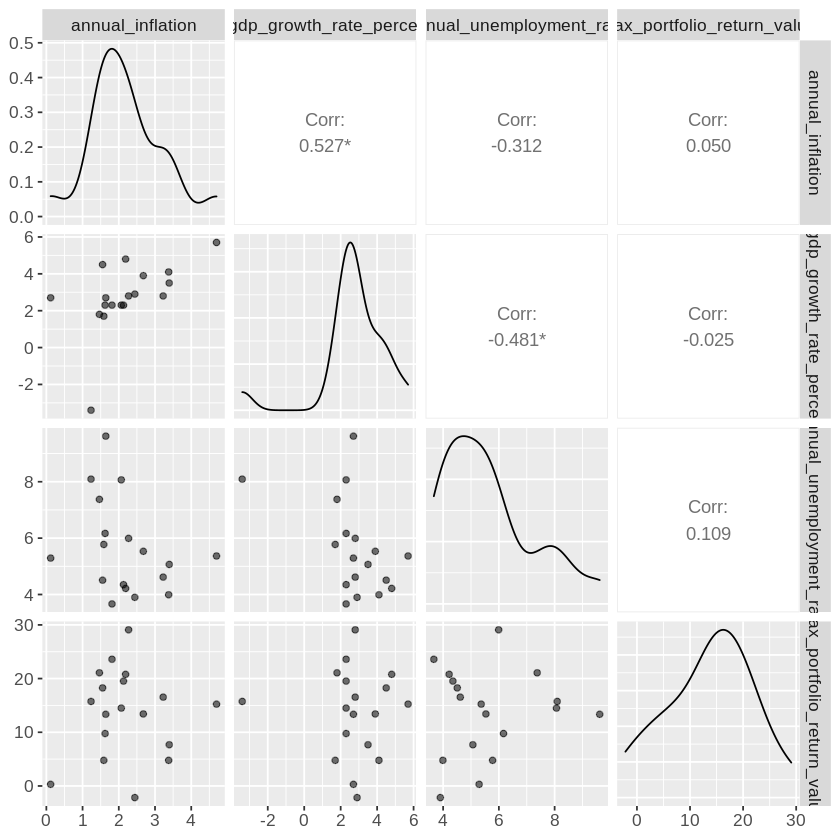

In [33]:
set.seed(9999)

pf_t_plot <- pf_training|>
    ggpairs(mapping=aes(alpha=0.05))+
    theme(text=element_text(size=13))
pf_t_plot

lm_specr <- linear_reg()|>
    set_engine("lm")|>
    set_mode("regression")

pf_reciper <- recipe(max_portfolio_return_value ~ ., data=pf_training)

pf_fitr <- workflow()|>
    add_recipe(pf_reciper)|>
    add_model(lm_specr)|>
    fit(data=pf_training)
pf_fitr

pf_rmsper <- pf_fit|>
    predict(pf_testing)|>
    bind_cols(pf_testing)|>
    metrics(truth=max_portfolio_return_value, estimate=.pred)|>
    filter(.metric=="rmse")|>
    select(.estimate)|>
    pull()
pf_rmsper

In [ ]:
#Requires more data
'
set.seed(9999)

# your code here
knn_recipe <- recipe(max_portfolio_return_value ~., data=pf_training)|>
                step_center(all_predictors())|>
                step_scale(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
            set_engine("kknn")|>
            set_mode("regression")

set_vfold <- vfold_cv(pf_training, v = 5, strata = max_portfolio_return_value)

knn_workflow <- workflow()|>
                add_recipe(knn_recipe)|>
                add_model(knn_spec)

gridvals <- tibble(neighbors=seq(1,18))

knn_results <- knn_workflow |>
                tune_grid(resample=set_vfold, grid=gridvals)|>
                collect_metrics()

kmin <- knn_results |>
        filter(.metric == "rmse")|>
        filter(mean == min(mean))|>
        pull(neighbors)

pf_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
                set_engine("kknn")|>
                set_mode("regression")

pf_fit2 <- workflow()|>
    add_recipe(knn_recipe)|>
    add_model(credit_spec)|>
    fit(data = pf_training)

knn_rmspe <- credit_fit |>
    predict(pf_testing)|>
    bind_cols(pf_testing)|>
    metrics(truth=max_portfolio_return_value, estimate = .pred)|>
    filter(.metric == "rmse")|>
    pull(.estimate)

knn_rmspe